In [111]:
import os, math
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from utils.dataset import load_dataset_v2
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans
from scipy.interpolate import CubicSpline

In [2]:
file_name_list = os.listdir(os.path.join('data', 'ver_2'))
file_path_list = []

for file_name in file_name_list:
    file_path_list.append(os.path.join('data', 'ver_2', file_name))

dataset= load_dataset_v2(file_path_list)
dataset = dataset[dataset['outlet_flowrate(lpm)'] > 1]
dataset.reset_index(drop=True, inplace=True)

dataset = dataset[::10]
dataset.reset_index(drop=True, inplace=True)

feature_col_name_list = ['pressure_1(bar)', 'main_pressure(bar)']
target_col_name = 'outlet_flowrate(lpm)'

train_data = dataset[dataset['test_case_iter']!=3]
val_data = dataset[dataset['test_case_iter']==3]

train_data = train_data[feature_col_name_list + [target_col_name]]
val_data = val_data[feature_col_name_list + [target_col_name]]

train_data['data_type'] = 'train data'
val_data['data_type'] = 'validation data'

dataset = pd.concat([train_data, val_data])

loading dataset...:   0%|          | 0/84 [00:00<?, ?it/s]

In [3]:
train_data.describe()

,pressure_1(bar),main_pressure(bar),outlet_flowrate(lpm)
count,132560.000000,132560.000000,132560.000000
mean,-0.155419,5.916312,999.994014
std,0.099546,5.759028,478.513498
min,-0.550000,-0.180000,1.010000
25%,-0.220000,2.010000,650.180000
50%,-0.150000,3.130000,1047.185000
75%,-0.100000,7.170000,1400.807500
max,0.410000,22.570000,2075.200000


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132560 entries, 0 to 194654
Data columns (total 4 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   pressure_1(bar)       132560 non-null  float64
 1   main_pressure(bar)    132560 non-null  float64
 2   outlet_flowrate(lpm)  132560 non-null  float64
 3   data_type             132560 non-null  object 
dtypes: float64(3), object(1)
memory usage: 5.1+ MB


In [5]:
val_data.describe()

,pressure_1(bar),main_pressure(bar),outlet_flowrate(lpm)
count,64000.000000,64000.000000,64000.000000
mean,-0.157004,6.034524,1003.800100
std,0.096690,5.990122,494.523933
min,-0.540000,-0.160000,1.010000
25%,-0.220000,2.000000,626.850000
50%,-0.150000,3.090000,1051.930000
75%,-0.100000,7.220000,1412.880000
max,0.390000,22.170000,2105.550000


In [6]:
val_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64000 entries, 5354 to 196559
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   pressure_1(bar)       64000 non-null  float64
 1   main_pressure(bar)    64000 non-null  float64
 2   outlet_flowrate(lpm)  64000 non-null  float64
 3   data_type             64000 non-null  object 
dtypes: float64(3), object(1)
memory usage: 2.4+ MB


<AxesSubplot:>

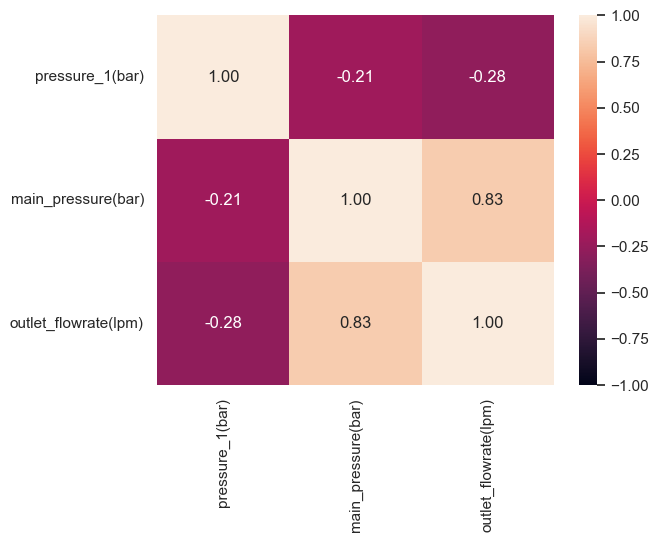

In [7]:
sns.set(font_scale=1.0)
sns.heatmap(dataset.corr(), annot=True, fmt='.2f', vmin=-1, vmax=1)

(-0.6, 0.6)

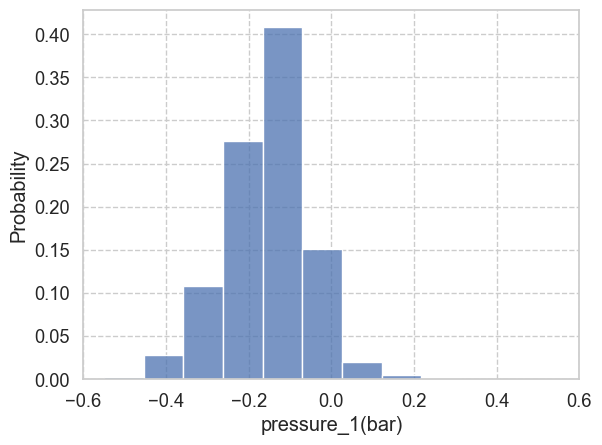

In [8]:
data_name = 'pressure_1(bar)'

sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
n_bin = math.ceil((dataset[data_name].max()-dataset[data_name].min())*10)

sns.histplot(dataset[data_name], stat='probability', bins=n_bin)

plt.xlim(-0.6, 0.6)

(-0.6, 0.6)

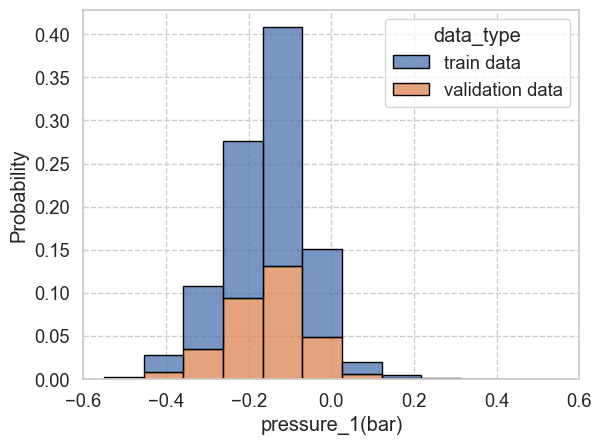

In [9]:
data_name = 'pressure_1(bar)'

sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

n_bin = math.ceil((dataset[data_name].max()-dataset[data_name].min())*10)
sns.histplot(data=dataset, x=data_name, hue='data_type', bins=n_bin, multiple='stack', stat='probability', edgecolor='black')

plt.xlim(-0.6, 0.6)

(0.0, 2500.0)

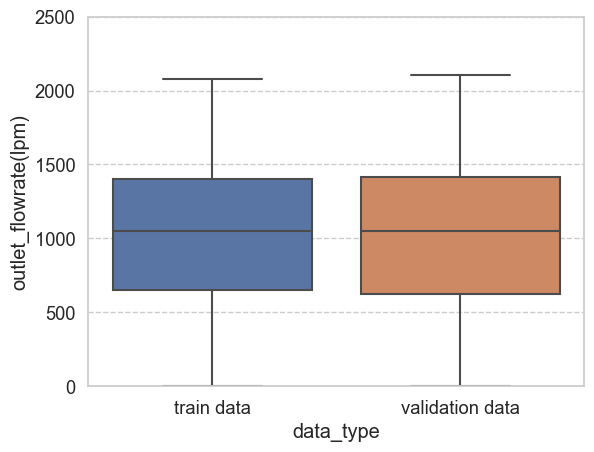

In [10]:
data_name = 'outlet_flowrate(lpm)'

sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.boxplot(data=dataset, x='data_type', y=data_name)

plt.ylim(0, 2500)

Text(0, 0.5, 'Venturi Pump Outlet Flow-rate(LPM)')

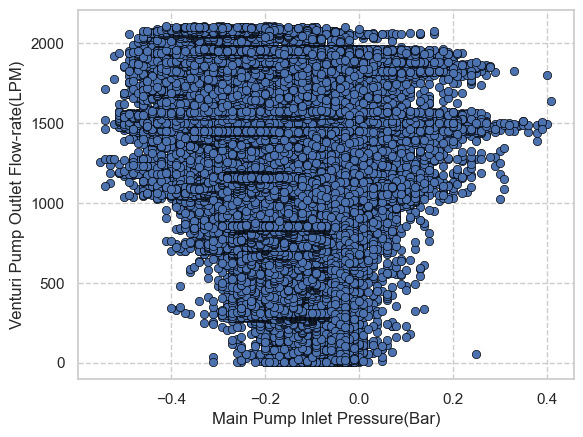

In [11]:
sns.set(font_scale=1)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.scatterplot(data=dataset, x='pressure_1(bar)', y='outlet_flowrate(lpm)', edgecolor='black')

plt.xlabel('Main Pump Inlet Pressure(Bar)')
plt.ylabel('Venturi Pump Outlet Flow-rate(LPM)')

In [220]:
p1 = dataset['pressure_1(bar)'].to_numpy()
p1 = p1[::10]
p1_int = p1*100
p1_int = p1_int-p1_int.min()
p1_int = p1_int.astype(np.int64)

p2 = dataset['main_pressure(bar)'].to_numpy()
p2 = p2[::10]
p2_int = p2*100
p2_int = p2_int-p2_int.min()
p2_int = p2_int.astype(np.int64)

flowrate = dataset['outlet_flowrate(lpm)'].to_numpy()
flowrate = flowrate[::10]
flowrate_int =flowrate.astype(np.int64)
flowrate_int = flowrate_int-flowrate_int.min()

In [239]:
data = np.vstack([p1, flowrate])
kde = gaussian_kde(data)
density = kde(data)

In [247]:
threshold = 0.003
mask = density >= threshold
filtered_x = p1[mask]
filtered_y = flowrate[mask]

Text(0, 0.5, 'Venturi Pump Outlet Flow-rate(LPM)')

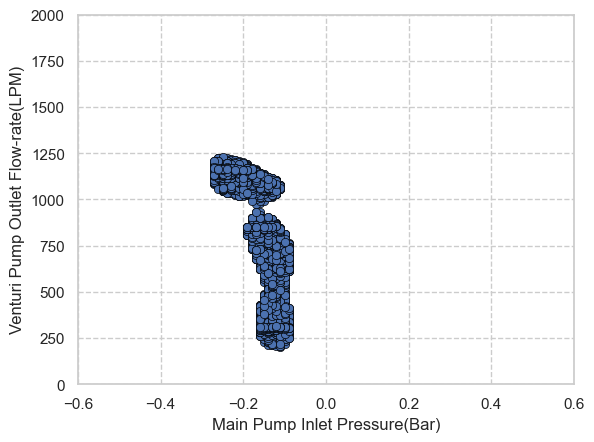

In [248]:
sns.set(font_scale=1)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.scatterplot(x=filtered_x, y=filtered_y, edgecolor='black')

plt.xlim(-0.6, 0.6)
plt.xlabel('Main Pump Inlet Pressure(Bar)')
plt.ylim(0, 2000)
plt.ylabel('Venturi Pump Outlet Flow-rate(LPM)')

Text(0, 0.5, 'Venturi Pump Outlet Flow-rate(LPM)')

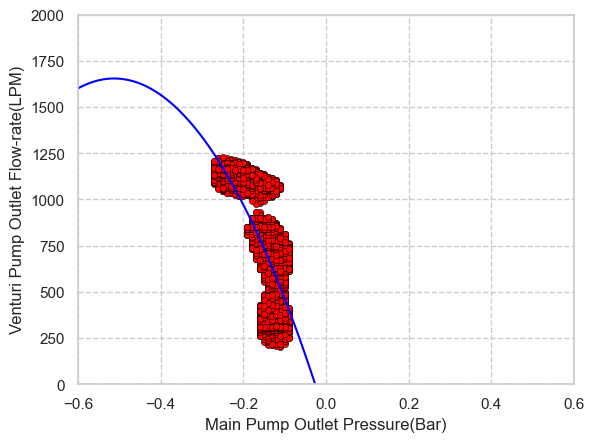

In [249]:
sns.set(font_scale=1)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

interp_coff = np.polyfit(filtered_x, filtered_y, 2)

new_x = np.linspace(-0.6, 0.6, 100)
p=np.poly1d(interp_coff)
new_y = p(new_x)

sns.lineplot(x=new_x, y=new_y, color='blue')
sns.scatterplot(x=filtered_x, y=filtered_y, color='red', marker='o', edgecolor='black', s=20)

plt.xlim(-0.6, 0.6)
plt.ylim(0, 2000)
plt.xlabel('Main Pump Outlet Pressure(Bar)')
plt.ylabel('Venturi Pump Outlet Flow-rate(LPM)')

ValueError: If using all scalar values, you must pass an index

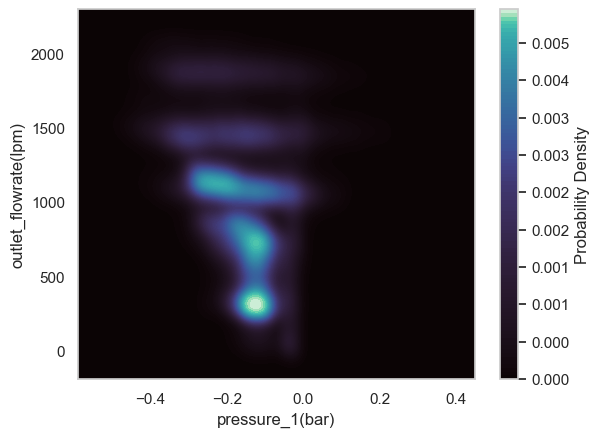

In [18]:
sns.set(font_scale=1)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.kdeplot(data=dataset, x='pressure_1(bar)', y='outlet_flowrate(lpm)', thresh=0, levels=100, fill=True, cmap='mako', cbar=True, cbar_kws={'label': 'Probability Density', 'format': '%.3f'})

plt.xlabel('Main Pump Inlet Pressure(Bar)')
plt.ylabel('Venturi Pump Outlet Flow-rate(LPM)')

Text(0, 0.5, 'Venturi Pump Outlet Flow-rate(LPM)')

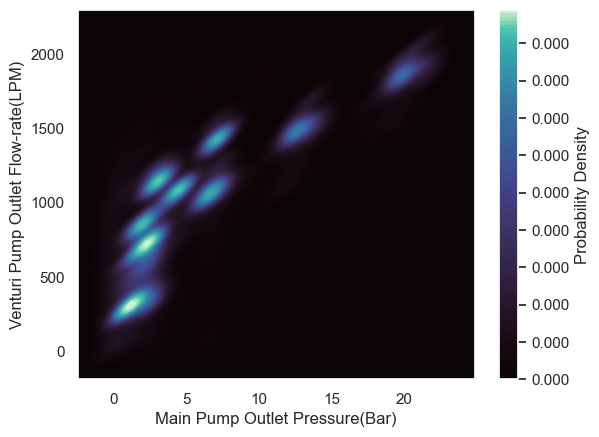

In [117]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_theme(style='dark')
sns.set(font_scale=1.0)

sns.kdeplot(data=dataset, x='main_pressure(bar)', y='outlet_flowrate(lpm)', thresh=0, levels=100, fill=True, cmap='mako', cbar=True, cbar_kws={'label': 'Probability Density', 'format': '%.3f'})

plt.xlabel('Main Pump Outlet Pressure(Bar)')
plt.ylabel('Venturi Pump Outlet Flow-rate(LPM)')

In [ ]:
sns.set(font_scale=1)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.displot(data=dataset, x='main_pressure(bar)', y='outlet_flowrate(lpm)', kind='kde', rug=True)

plt.xlabel('Main Pump Inlet Pressure(Bar)')
plt.ylabel('Venturi Pump Outlet Flow-rate(LPM)')